---
## Step 1: Setup and Imports

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Add parent directory for MAPS import
sys.path.insert(0, '..')

# Clear cached imports
for mod_name in list(sys.modules.keys()):
    if 'MAPS' in mod_name or 'maps' in mod_name:
        del sys.modules[mod_name]

from MAPS.cell_phenotyping import Trainer, Predictor
from MAPS.cell_phenotyping.datasets import CellExpressionCSV

print("✅ All imports successful!")
print(f"📂 Working directory: {os.getcwd()}")

✅ All imports successful!
📂 Working directory: c:\Users\mahee\OneDrive\Documents\Semester-12\FYDP-2\MAPS\Experiments_my_ideas


In [2]:
# Check GPU
print("🖥️ Hardware Check:")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA version: {torch.version.cuda}")
    device = torch.device('cuda')
else:
    print("   Running on CPU")
    device = torch.device('cpu')

🖥️ Hardware Check:
   CUDA available: True
   GPU: NVIDIA GeForce GTX 1650
   CUDA version: 12.1


---
## Step 2: Define Custom 6-Layer MLP

### Architecture Comparison:

**MAPS 4-Layer MLP:**
```
Input → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Classifier(num_classes)
```

**Our 6-Layer MLP:**
```
Input → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout
      → Linear(512) → ReLU → Dropout  ← NEW
      → Linear(512) → ReLU → Dropout  ← NEW
      → Classifier(num_classes)
```

In [3]:
class MLP_6Layer(nn.Module):
    """
    6-Layer Multi-Layer Perceptron
    
    Deeper architecture with 6 hidden layers instead of 4.
    """
    def __init__(self, input_dim=50, hidden_dim=512, num_classes=16, dropout=0.10):
        super(MLP_6Layer, self).__init__()
        
        # 6 hidden layers
        self.fc = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            # Layer 2
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            # Layer 3
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            # Layer 4
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            # Layer 5 (NEW)
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            # Layer 6 (NEW)
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
        
        # Output classifier
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, batch):
        """
        Forward pass
        
        Args:
            batch: Input tensor of shape (batch_size, input_dim)
        
        Returns:
            logits: Raw output scores
            probs: Softmax probabilities
        """
        features = self.fc(batch)
        logits = self.classifier(features)
        probs = torch.softmax(logits, dim=-1)
        return logits, probs

print("✅ 6-Layer MLP defined!")

# Test instantiation
test_model = MLP_6Layer(input_dim=50, hidden_dim=512, num_classes=16, dropout=0.10)
total_params = sum(p.numel() for p in test_model.parameters())
print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"\n   (4-layer MAPS has ~1.3M params, this has more!)")

✅ 6-Layer MLP defined!

📊 Model Statistics:
   Total parameters: 1,347,600

   (4-layer MAPS has ~1.3M params, this has more!)


---
## Step 3: Load Preprocessed Data

In [4]:
# Use the data preprocessed from previous notebook
data_dir = './cHL_CODEX_processed'
train_path = os.path.join(data_dir, 'train.csv')
valid_path = os.path.join(data_dir, 'valid.csv')
class_path = os.path.join(data_dir, 'class_names.csv')

# Check if files exist
if not os.path.exists(train_path):
    print("❌ Preprocessed data not found!")
    print("   Please run 'cHL_CODEX_training_comparison.ipynb' first to generate the data.")
else:
    print("✅ Found preprocessed data!")
    
    # Load class info
    class_df = pd.read_csv(class_path)
    NUM_CLASSES = len(class_df)
    
    # Load to check dimensions
    train_df = pd.read_csv(train_path)
    NUM_FEATURES = len(train_df.columns) - 1  # Exclude 'cell_label'
    
    print(f"\n📊 Dataset Info:")
    print(f"   Training samples: {len(train_df):,}")
    print(f"   Features: {NUM_FEATURES}")
    print(f"   Classes: {NUM_CLASSES}")
    print(f"\n   Class names: {', '.join(class_df['class_name'].tolist())}")

✅ Found preprocessed data!

📊 Dataset Info:
   Training samples: 114,984
   Features: 50
   Classes: 16

   Class names: B, CD4, CD8, DC, Endothelial, Epithelial, Lymphatic, M1, M2, Mast, Monocyte, NK, Neutrophil, Other, TReg, Tumor


---
## Step 4: Custom Training Loop for 6-Layer MLP

Since we're using a custom architecture, we need a custom training loop.

In [5]:
# Training configuration
BATCH_SIZE = 512 if torch.cuda.is_available() else 128
LEARNING_RATE = 0.001
DROPOUT = 0.10
MAX_EPOCHS = 100
MIN_EPOCHS = 20
PATIENCE = 20
SEED = 42

print("⚙️ Training Configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Dropout: {DROPOUT}")
print(f"   Max epochs: {MAX_EPOCHS}")
print(f"   Patience: {PATIENCE}")
print(f"   Device: {device}")

⚙️ Training Configuration:
   Batch size: 512
   Learning rate: 0.001
   Dropout: 0.1
   Max epochs: 100
   Patience: 20
   Device: cuda


In [6]:
# Set seeds for reproducibility
import random

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("✅ Seeds set for reproducibility")

✅ Seeds set for reproducibility


In [7]:
# Load data
print("📂 Loading datasets...")

train_dataset = CellExpressionCSV(train_path, is_train=True)
valid_dataset = CellExpressionCSV(valid_path, is_train=False, 
                                  mean=train_dataset.mean, 
                                  std=train_dataset.std)

train_loader = CellExpressionCSV.get_data_loader(train_dataset, batch_size=BATCH_SIZE, 
                                                  is_train=True, num_workers=4 if torch.cuda.is_available() else 0)
valid_loader = CellExpressionCSV.get_data_loader(valid_dataset, batch_size=BATCH_SIZE, 
                                                  is_train=False, num_workers=4 if torch.cuda.is_available() else 0)

print(f"✅ Data loaded!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Valid batches: {len(valid_loader)}")

📂 Loading datasets...
✅ Data loaded!
   Train batches: 224
   Valid batches: 57


In [8]:
# Initialize model
print("🚀 Initializing 6-Layer MLP...")

model = MLP_6Layer(input_dim=NUM_FEATURES, hidden_dim=512, 
                   num_classes=NUM_CLASSES, dropout=DROPOUT)
model.to(device, dtype=torch.float64)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("✅ Model initialized!")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Device: {next(model.parameters()).device}")

🚀 Initializing 6-Layer MLP...
✅ Model initialized!
   Parameters: 1,347,600
   Device: cuda:0


In [9]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for features, labels in loader:
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits, probs = model(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in loader:
            features = features.to(device)
            labels = labels.to(device)
            
            logits, probs = model(features)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels

print("✅ Training functions defined!")

✅ Training functions defined!


---
## Step 5: Train the 6-Layer Model

In [10]:
print("\n" + "="*60)
print("TRAINING 6-LAYER MLP")
print("="*60)

# Training tracking
results_dir = './results_6layer_model/'
os.makedirs(results_dir, exist_ok=True)

history = {
    'train_loss': [], 'train_acc': [],
    'valid_loss': [], 'valid_acc': []
}

best_valid_loss = float('inf')
patience_counter = 0
best_model_path = os.path.join(results_dir, 'best_6layer_model.pt')

start_time = time.time()

for epoch in range(MAX_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    valid_loss, valid_acc, _, _ = validate_epoch(model, valid_loader, criterion, device)
    
    # Record
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch {epoch+1:3d}/{MAX_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Valid Loss: {valid_loss:.4f} Acc: {valid_acc:.4f} | "
          f"Time: {epoch_time:.1f}s")
    
    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_mean': train_dataset.mean,
            'train_std': train_dataset.std,
            'valid_loss': valid_loss,
            'valid_acc': valid_acc
        }, best_model_path)
        print(f"  → 💾 Saved best model (valid_loss: {valid_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE and epoch >= MIN_EPOCHS:
            print(f"\n⏹️  Early stopping triggered after {epoch+1} epochs")
            break

training_time = time.time() - start_time

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print(f"\n⏱️  Total time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"📊 Epochs: {len(history['train_loss'])}")
print(f"🎯 Best valid loss: {best_valid_loss:.4f}")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(os.path.join(results_dir, 'training_logs.csv'), index=False)
print(f"💾 Training logs saved to: {results_dir}training_logs.csv")


TRAINING 6-LAYER MLP
Epoch   1/100 | Train Loss: 2.4323 Acc: 0.1515 | Valid Loss: 2.1758 Acc: 0.2343 | Time: 48.1s
  → 💾 Saved best model (valid_loss: 2.1758)
Epoch   2/100 | Train Loss: 1.6592 Acc: 0.4250 | Valid Loss: 1.4830 Acc: 0.4708 | Time: 44.8s
  → 💾 Saved best model (valid_loss: 1.4830)
Epoch   3/100 | Train Loss: 1.0859 Acc: 0.6524 | Valid Loss: 1.2219 Acc: 0.5892 | Time: 46.7s
  → 💾 Saved best model (valid_loss: 1.2219)
Epoch   4/100 | Train Loss: 0.9274 Acc: 0.7087 | Valid Loss: 1.0693 Acc: 0.6444 | Time: 47.4s
  → 💾 Saved best model (valid_loss: 1.0693)
Epoch   5/100 | Train Loss: 0.8178 Acc: 0.7434 | Valid Loss: 0.8966 Acc: 0.7027 | Time: 45.2s
  → 💾 Saved best model (valid_loss: 0.8966)
Epoch   6/100 | Train Loss: 0.7249 Acc: 0.7734 | Valid Loss: 0.9113 Acc: 0.7071 | Time: 45.2s
Epoch   7/100 | Train Loss: 0.6642 Acc: 0.7926 | Valid Loss: 0.7626 Acc: 0.7539 | Time: 46.2s
  → 💾 Saved best model (valid_loss: 0.7626)
Epoch   8/100 | Train Loss: 0.6339 Acc: 0.8009 | Valid L

---
## Step 6: Visualize Training Progress

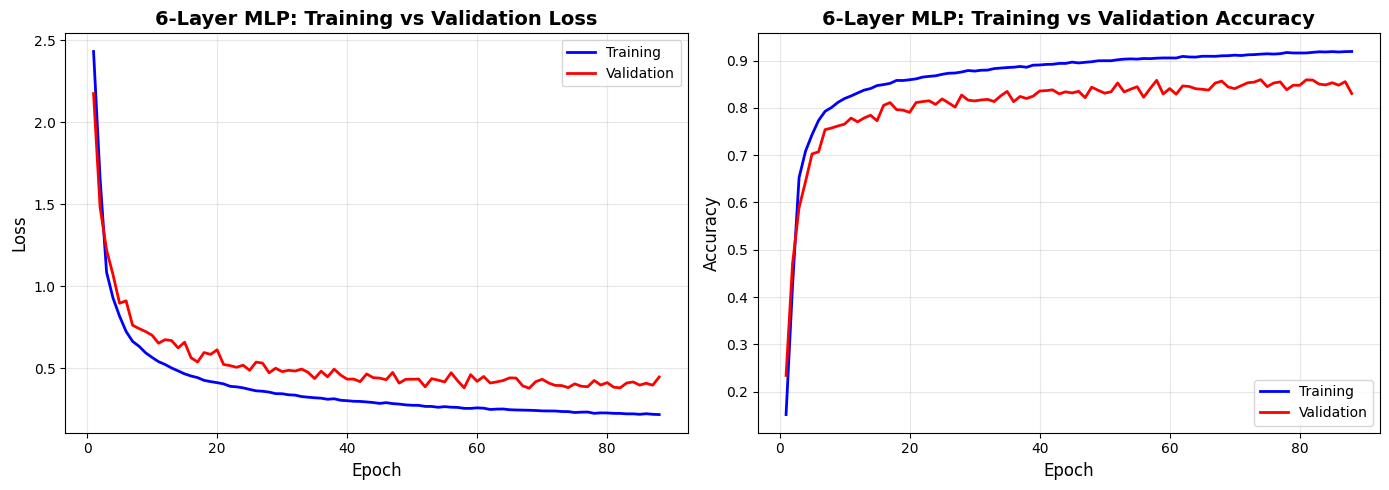


📊 Training Summary:
   Final train accuracy: 0.9192
   Final valid accuracy: 0.8302
   Best valid accuracy: 0.8597
   Time per epoch: 46.78s


In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Training', linewidth=2)
axes[0].plot(epochs, history['valid_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('6-Layer MLP: Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Training', linewidth=2)
axes[1].plot(epochs, history['valid_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('6-Layer MLP: Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Training Summary:")
print(f"   Final train accuracy: {history['train_acc'][-1]:.4f}")
print(f"   Final valid accuracy: {history['valid_acc'][-1]:.4f}")
print(f"   Best valid accuracy: {max(history['valid_acc']):.4f}")
print(f"   Time per epoch: {training_time/len(epochs):.2f}s")

---
## Step 7: Evaluate 6-Layer Model

In [12]:
# Load best model
print("📦 Loading best 6-layer model...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"   Valid loss: {checkpoint['valid_loss']:.4f}")
print(f"   Valid acc: {checkpoint['valid_acc']:.4f}")

📦 Loading best 6-layer model...
✅ Loaded model from epoch 68
   Valid loss: 0.3782
   Valid acc: 0.8566


C:\Users\mahee\AppData\Local\Temp\ipykernel_24936\189611122.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


In [13]:
# Get predictions
print("\n🔮 Making predictions...")
_, _, pred_labels_6layer, gt_labels = validate_epoch(model, valid_loader, criterion, device)

accuracy_6layer = accuracy_score(gt_labels, pred_labels_6layer)
print(f"\n🎯 6-LAYER MODEL ACCURACY: {accuracy_6layer:.4f} ({accuracy_6layer*100:.2f}%)")


🔮 Making predictions...

🎯 6-LAYER MODEL ACCURACY: 0.8566 (85.66%)


In [14]:
# Classification report
print("\n📋 CLASSIFICATION REPORT (6-Layer Model):")
print("="*70)
print(classification_report(gt_labels, pred_labels_6layer, 
                          target_names=class_df['class_name'].tolist(), 
                          digits=3))


📋 CLASSIFICATION REPORT (6-Layer Model):
              precision    recall  f1-score   support

           B      0.894     0.861     0.877      3240
         CD4      0.931     0.773     0.845      7496
         CD8      0.927     0.901     0.914      3514
          DC      0.819     0.799     0.809      1927
 Endothelial      0.939     0.881     0.909      1741
  Epithelial      0.725     0.944     0.820       450
   Lymphatic      0.820     0.973     0.890       754
          M1      0.640     0.890     0.745       620
          M2      0.791     0.880     0.833      1457
        Mast      0.921     0.967     0.944       665
    Monocyte      0.792     0.845     0.818      1382
          NK      0.873     0.896     0.884      1468
  Neutrophil      0.834     0.932     0.880       688
       Other      0.757     0.878     0.813      1021
        TReg      0.500     0.878     0.637       671
       Tumor      0.915     0.941     0.928      1652

    accuracy                          

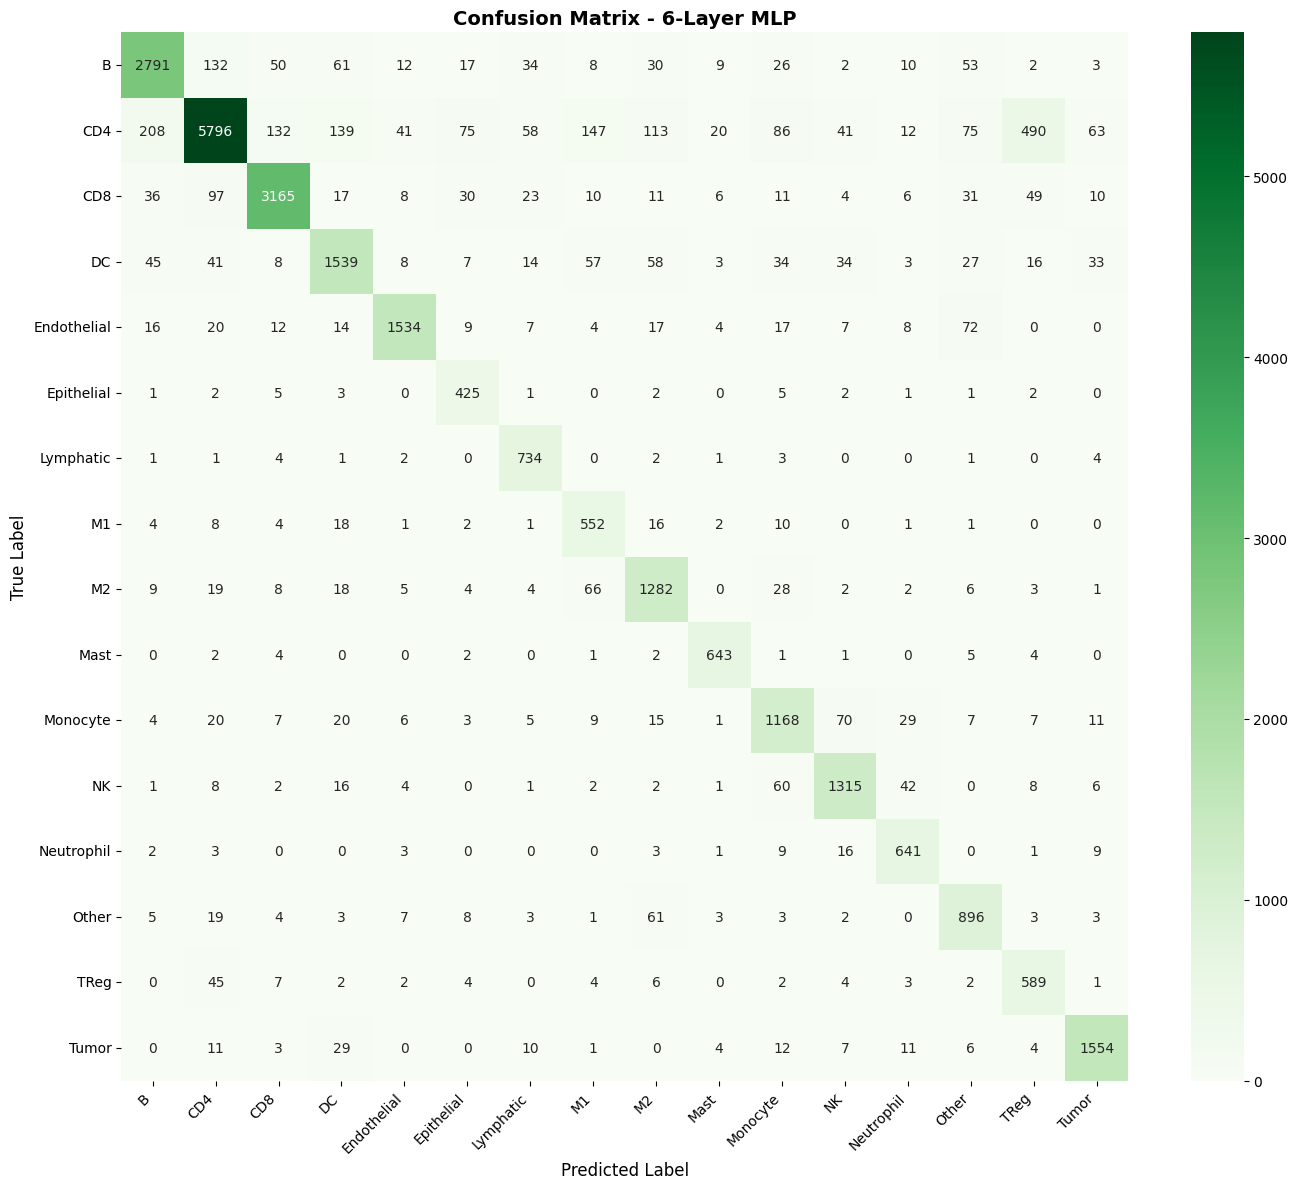

In [15]:
# Confusion matrix
cm_6layer = confusion_matrix(gt_labels, pred_labels_6layer)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_6layer, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_df['class_name'].tolist(),
            yticklabels=class_df['class_name'].tolist())
plt.title('Confusion Matrix - 6-Layer MLP', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
## Step 8: Compare with 4-Layer and Pretrained Models

In [16]:
# Load results from previous 4-layer experiment
prev_results_path = './results_new_model/training_logs.csv'

if os.path.exists(prev_results_path):
    print("📊 Loading 4-layer model results...")
    
    # Train 4-layer predictor to get accuracy
    trainer_4layer = Trainer(
        model_checkpoint_path='./results_new_model/best_checkpoint.pt',
        results_dir='./results_new_model/',
        num_features=NUM_FEATURES,
        num_classes=NUM_CLASSES,
        batch_size=BATCH_SIZE
    )
    
    pred_labels_4layer, _ = trainer_4layer.predict(valid_path)
    accuracy_4layer = accuracy_score(gt_labels, pred_labels_4layer)
    
    print(f"✅ 4-layer model accuracy: {accuracy_4layer:.4f}")
else:
    print("⚠️ 4-layer model results not found. Run the previous notebook first.")
    accuracy_4layer = None
    pred_labels_4layer = None

📊 Loading 4-layer model results...
Batch 57/57            ✅ 4-layer model accuracy: 0.8576


In [17]:
# Load MAPS pretrained model
pretrained_path = '../models/cell_phenotyping/cHL_CODEX.pt'

if os.path.exists(pretrained_path):
    print("📦 Loading MAPS pretrained model...")
    
    pretrained_predictor = Predictor(
        model_checkpoint_path=pretrained_path,
        num_features=NUM_FEATURES,
        num_classes=NUM_CLASSES,
        batch_size=BATCH_SIZE
    )
    
    pred_labels_pretrained, _ = pretrained_predictor.predict(valid_path)
    accuracy_pretrained = accuracy_score(gt_labels, pred_labels_pretrained)
    
    print(f"✅ Pretrained model accuracy: {accuracy_pretrained:.4f}")
else:
    print("⚠️ Pretrained model not found.")
    accuracy_pretrained = None
    pred_labels_pretrained = None

📦 Loading MAPS pretrained model...
Batch 57/57            ✅ Pretrained model accuracy: 0.9080


In [18]:
# Comprehensive comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

print(f"\n🆕 6-Layer MLP (your model):         {accuracy_6layer:.4f} ({accuracy_6layer*100:.2f}%)")

if accuracy_4layer is not None:
    print(f"📊 4-Layer MLP (standard MAPS):      {accuracy_4layer:.4f} ({accuracy_4layer*100:.2f}%)")
    print(f"   → Difference (6L vs 4L): {(accuracy_6layer - accuracy_4layer)*100:+.2f}%")

if accuracy_pretrained is not None:
    print(f"📦 Pretrained MAPS (500 epochs):     {accuracy_pretrained:.4f} ({accuracy_pretrained*100:.2f}%)")
    print(f"   → Difference (6L vs pretrained): {(accuracy_6layer - accuracy_pretrained)*100:+.2f}%")

print("\n📈 Analysis:")
if accuracy_4layer is not None:
    if accuracy_6layer > accuracy_4layer:
        print("   ✅ The deeper 6-layer architecture performs BETTER!")
        print("   💡 More layers helped capture complex patterns.")
    elif accuracy_6layer > accuracy_4layer - 0.01:
        print("   ⚖️  Both architectures perform similarly.")
        print("   💡 Adding layers didn't hurt, but didn't help much either.")
    else:
        print("   ⚠️ The 4-layer model performed slightly better.")
        print("   💡 Deeper isn't always better - may need more regularization.")


MODEL COMPARISON

🆕 6-Layer MLP (your model):         0.8566 (85.66%)
📊 4-Layer MLP (standard MAPS):      0.8576 (85.76%)
   → Difference (6L vs 4L): -0.10%
📦 Pretrained MAPS (500 epochs):     0.9080 (90.80%)
   → Difference (6L vs pretrained): -5.14%

📈 Analysis:
   ⚖️  Both architectures perform similarly.
   💡 Adding layers didn't hurt, but didn't help much either.


---
## Step 9: Per-Class Comparison


📊 PER-CLASS F1 SCORE COMPARISON:
      Class  Count  6-Layer F1  4-Layer F1  Improvement
 Neutrophil    688       0.880       0.856        0.024
   Monocyte   1382       0.818       0.803        0.015
         M1    620       0.745       0.738        0.007
         NK   1468       0.884       0.878        0.006
          B   3240       0.877       0.873        0.004
        CD4   7496       0.845       0.843        0.001
      Tumor   1652       0.928       0.927        0.001
        CD8   3514       0.914       0.915       -0.002
  Lymphatic    754       0.890       0.892       -0.002
         M2   1457       0.833       0.836       -0.003
       Mast    665       0.944       0.947       -0.003
Endothelial   1741       0.909       0.913       -0.004
         DC   1927       0.809       0.814       -0.005
 Epithelial    450       0.820       0.829       -0.009
       TReg    671       0.637       0.661       -0.024
      Other   1021       0.813       0.845       -0.032


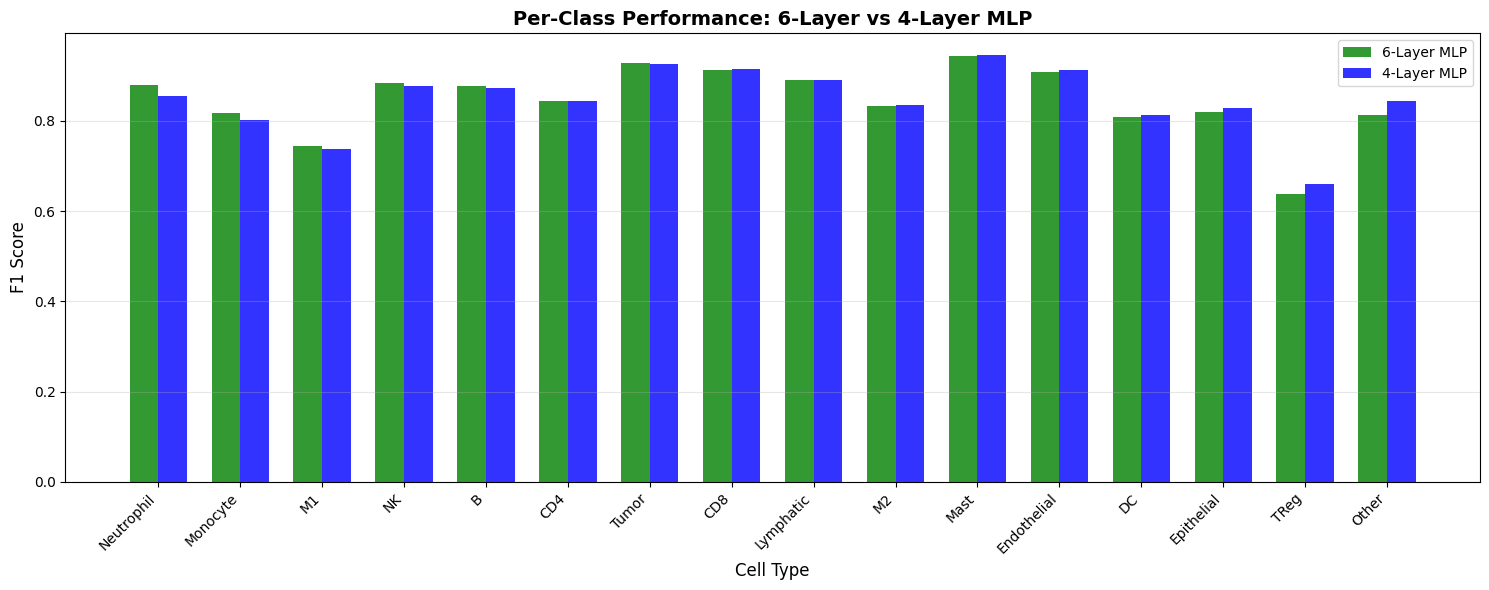


🎉 Classes where 6-layer improves significantly:
   Neutrophil: +0.024

⚠️ Classes where 6-layer performs worse:
   TReg: -0.024
   Other: -0.032


In [19]:
# Calculate F1 scores per class
if accuracy_4layer is not None:
    print("\n📊 PER-CLASS F1 SCORE COMPARISON:")
    print("="*100)
    
    comparison_data = []
    for i, class_name in enumerate(class_df['class_name']):
        gt_binary = (np.array(gt_labels) == i).astype(int)
        
        pred_6l_binary = (np.array(pred_labels_6layer) == i).astype(int)
        f1_6layer = f1_score(gt_binary, pred_6l_binary, zero_division=0)
        
        pred_4l_binary = (np.array(pred_labels_4layer) == i).astype(int)
        f1_4layer = f1_score(gt_binary, pred_4l_binary, zero_division=0)
        
        comparison_data.append({
            'Class': class_name,
            'Count': (np.array(gt_labels) == i).sum(),
            '6-Layer F1': f1_6layer,
            '4-Layer F1': f1_4layer,
            'Improvement': f1_6layer - f1_4layer
        })
    
    comp_df = pd.DataFrame(comparison_data)
    comp_df = comp_df.sort_values('Improvement', ascending=False)
    
    print(comp_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
    
    # Visualize
    plt.figure(figsize=(15, 6))
    x = np.arange(len(comp_df))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, comp_df['6-Layer F1'], width, label='6-Layer MLP', alpha=0.8, color='green')
    bars2 = plt.bar(x + width/2, comp_df['4-Layer F1'], width, label='4-Layer MLP', alpha=0.8, color='blue')
    
    plt.xlabel('Cell Type', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Per-Class Performance: 6-Layer vs 4-Layer MLP', fontsize=14, fontweight='bold')
    plt.xticks(x, comp_df['Class'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Highlight improvements
    improvements = comp_df[comp_df['Improvement'] > 0.02]
    if len(improvements) > 0:
        print("\n🎉 Classes where 6-layer improves significantly:")
        for _, row in improvements.iterrows():
            print(f"   {row['Class']}: +{row['Improvement']:.3f}")
    
    degradations = comp_df[comp_df['Improvement'] < -0.02]
    if len(degradations) > 0:
        print("\n⚠️ Classes where 6-layer performs worse:")
        for _, row in degradations.iterrows():
            print(f"   {row['Class']}: {row['Improvement']:.3f}")

---
## Step 10: Final Summary & Conclusions

In [20]:
print("\n" + "="*70)
print("🏁 EXPERIMENT SUMMARY: 6-LAYER MLP")
print("="*70)

print(f"\n🏗️ Architecture:")
print(f"   Layers: 6 hidden layers (vs 4 in standard MAPS)")
print(f"   Hidden units: 512 per layer")
print(f"   Dropout: {DROPOUT}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\n⏱️ Training:")
print(f"   Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"   Epochs: {len(history['train_loss'])}")
print(f"   Device: {device}")
print(f"   Batch size: {BATCH_SIZE}")

print(f"\n🎯 Performance:")
print(f"   6-Layer MLP: {accuracy_6layer:.4f} ({accuracy_6layer*100:.2f}%)")
if accuracy_4layer is not None:
    print(f"   4-Layer MLP: {accuracy_4layer:.4f} ({accuracy_4layer*100:.2f}%)")
    print(f"   Improvement: {(accuracy_6layer - accuracy_4layer)*100:+.2f}%")

print(f"\n💾 Saved Files:")
print(f"   Model: {best_model_path}")
print(f"   Logs: {results_dir}training_logs.csv")

print("\n🔬 Conclusions:")
if accuracy_4layer is not None:
    diff = accuracy_6layer - accuracy_4layer
    if diff > 0.01:
        print("   ✅ Deeper architecture (6 layers) provides measurable improvement")
        print("   💡 Consider trying even deeper networks (8 layers?)")
    elif diff > -0.01:
        print("   ⚖️  Performance is comparable - depth didn't significantly help")
        print("   💡 4 layers may be sufficient for this task")
    else:
        print("   ⚠️ Deeper network underperformed slightly")
        print("   💡 May need different hyperparameters (learning rate, dropout)")

print("\n💡 Next Experiments to Try:")
print("   1. Try 8-layer MLP (go even deeper)")
print("   2. Try different hidden dimensions (256, 768, 1024)")
print("   3. Try different dropout rates (0.05, 0.15, 0.20)")
print("   4. Try batch normalization between layers")
print("   5. Try residual connections (ResNet-style)")
print("   6. Try different activation functions (LeakyReLU, ELU)")

print("\n✅ Experiment complete!")


🏁 EXPERIMENT SUMMARY: 6-LAYER MLP

🏗️ Architecture:
   Layers: 6 hidden layers (vs 4 in standard MAPS)
   Hidden units: 512 per layer
   Dropout: 0.1
   Total parameters: 1,347,600

⏱️ Training:
   Time: 4116.59 seconds (68.61 minutes)
   Epochs: 88
   Device: cuda
   Batch size: 512

🎯 Performance:
   6-Layer MLP: 0.8566 (85.66%)
   4-Layer MLP: 0.8576 (85.76%)
   Improvement: -0.10%

💾 Saved Files:
   Model: ./results_6layer_model/best_6layer_model.pt
   Logs: ./results_6layer_model/training_logs.csv

🔬 Conclusions:
   ⚖️  Performance is comparable - depth didn't significantly help
   💡 4 layers may be sufficient for this task

💡 Next Experiments to Try:
   1. Try 8-layer MLP (go even deeper)
   2. Try different hidden dimensions (256, 768, 1024)
   3. Try different dropout rates (0.05, 0.15, 0.20)
   4. Try batch normalization between layers
   5. Try residual connections (ResNet-style)
   6. Try different activation functions (LeakyReLU, ELU)

✅ Experiment complete!
